#ARIMA Baseline

Here we try to apply ARIMA (more generally SARIMAX) model to our data to have a baseline performance. ARIMA models are good for cases with limited data, they are simple models that are usefull as for data analysis (provide confidence intervals, significance levels for estimated parameters etc). But there are critical issues, that means ARIMA might not be our best bet:

1) Too simple. ARIMA models are very simple, it can only account for linear component in data. Though it results in more robust convergence then, let's say, neural networks. And they are still very flexible for capturing complex patterns, but It's upper bound for accuracy is limited, can't account for complex non-linear phenomena.

2) Not scalable. When we go from simple ARIMA model to more expressive SARIMA, we will encounter the issue of bad scalability, the convrgence rate decreases fast with bigger season and more differencing, which are essential for capturing non-linear phenomena.

3) Different parameters, which there are very few, are highly non independent. It might seem that AR and MA and diif order parameters are fundamentally different, but in reality they tennd to mimic each other: AR can resembel differencing, AR and MA terms can cancel each other out, MA can mimic integration etc. (for example, AR-MA duality principle). For more info see https://people.duke.edu/~rnau/411arim.htm.

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm
from joblib import Parallel, delayed

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error

def unit_root_test(series):
    '''provides adfuller test and check if the p value is below 0.05 or not. Unit root test is used to
      estimate the stationalrity of a time series. Stationarity is assumed by models like ARIMA'''
    pval = adfuller(series)[1] #returns (satisticts, p-values, ...) so we need adf[1]

    if pval < 0.05:
        print(f"p-value = {pval} => time series has no unit root")
    else:
        print(f"p-value = {pval} => time has a unit root")

def stl_detrend(df, n_jobs=-1):

    '''deletes trend using stl decomposition, returns residual+seasonal component of the input dataframe'''

    def process_single_column(args):
        series = args

        try:
            stl = STL(series, period=96, seasonal=9, robust=True)
            result = stl.fit()

            reconstructed = result.seasonal + result.resid

            return reconstructed.values
        except Exception as e:
            print(f"STL failed for series: {e}")
            return series

    colomn_names = df.columns

    args = [df[name] for name in colomn_names]

    reconstructed_values = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(process_single_column)(arg) for arg in tqdm(args, total=len(colomn_names))
    )

    df = pd.DataFrame(np.column_stack(reconstructed_values), index=df.index, columns=df.columns)

    return df


#Data Loading

Let's load our data. Here we will focus on one meter's plot withing a shorter time range, because the full time series is too long and might expirience distrubution shifting

In [56]:
n = 1

df = pd.read_csv("deNaNed_energy.csv")
df["Time"] = pd.to_datetime(df["Time"])
df = df.set_index("Time")
df = df[[f'Energy_Meter_{n}']]

date_start = np.datetime64("2022-09-01")
date_end = np.datetime64("2022-09-14")
time_mask = (df.index <= date_end) & (df.index >= date_start)
df_short = df[time_mask]
df

,Energy_Meter_1
Time,
2022-05-05 12:00:00,0.068
2022-05-05 12:15:00,0.070
2022-05-05 12:30:00,0.122
2022-05-05 12:45:00,0.132
2022-05-05 13:00:00,0.125
...,...
2023-05-31 23:00:00,0.194
2023-05-31 23:15:00,0.227
2023-05-31 23:30:00,0.224


In [57]:
#Train-Test split
train_mask = df_short.index <= (date_end - 2)
test_mask = df_short.index > (date_end - 2)

train_df = df_short[train_mask].rename(columns = {f"Energy_Meter_{n}" : "train"})
test_df = df_short[test_mask].rename(columns = {f"Energy_Meter_{n}" : "test"})

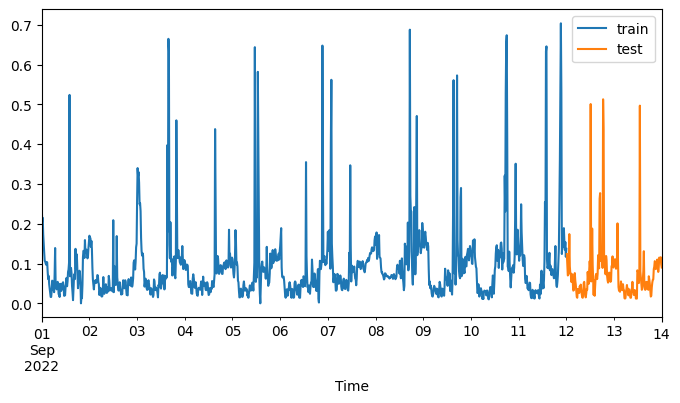

In [58]:
_,ax = plt.subplots(1,1, figsize=(8,4))
train_df.plot(ax=ax)
test_df.plot(ax=ax)
plt.show()

Now we perform adfuller test for the presense of a unit root (or AR(p)'s operational polynomial, corresponds to unstable, nonstationary forecasting) We see that even without any addional processing the data is quite stationary!

In [59]:
unit_root_test(train_df['train'])

p-value = 6.426080164803999e-14 => time series has no unit root


Let's take a look at ACF and PACF plots to get more information about a possible ARIMA configurations. In anticipation of seasonal correlation, I take lags=96 - which corresponds to a full day. On PACF plot we see spikes in the first lag (0's lag is always 1), wherein ACF plot shows more gradial decay, this looks like an "AR signature" suggesting we need to use AR(1) model. But we also see a strong seasonal component in the form of periodic waves above significance level (significance area corresponds to white noise correlations). It seems like a seasonal diff is required!

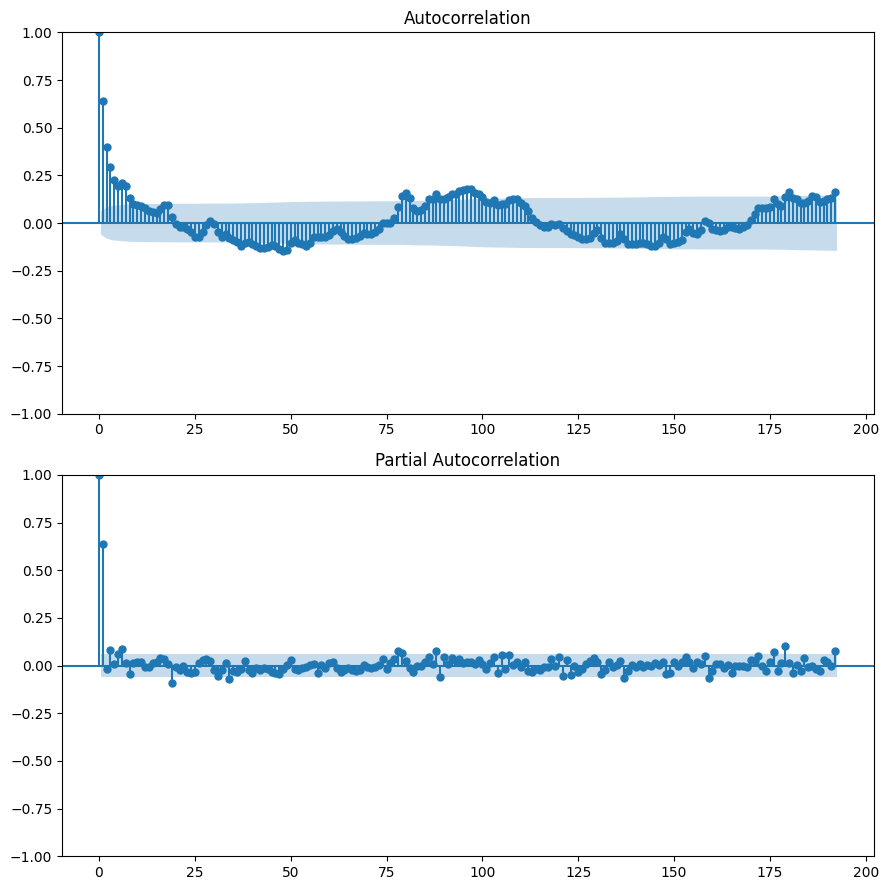

In [60]:
_,(ax1, ax2) = plt.subplots(2, 1, figsize=(9, 9))

plot_acf(train_df['train'], lags=192, ax=ax1)
plot_pacf(train_df['train'], lags=192, ax=ax2)
plt.tight_layout()
plt.show()

Now we investigate different diffencing configurations and thier properties

In [61]:
diffs = (1, 24, 48, 96) #what diff orders we are going to track

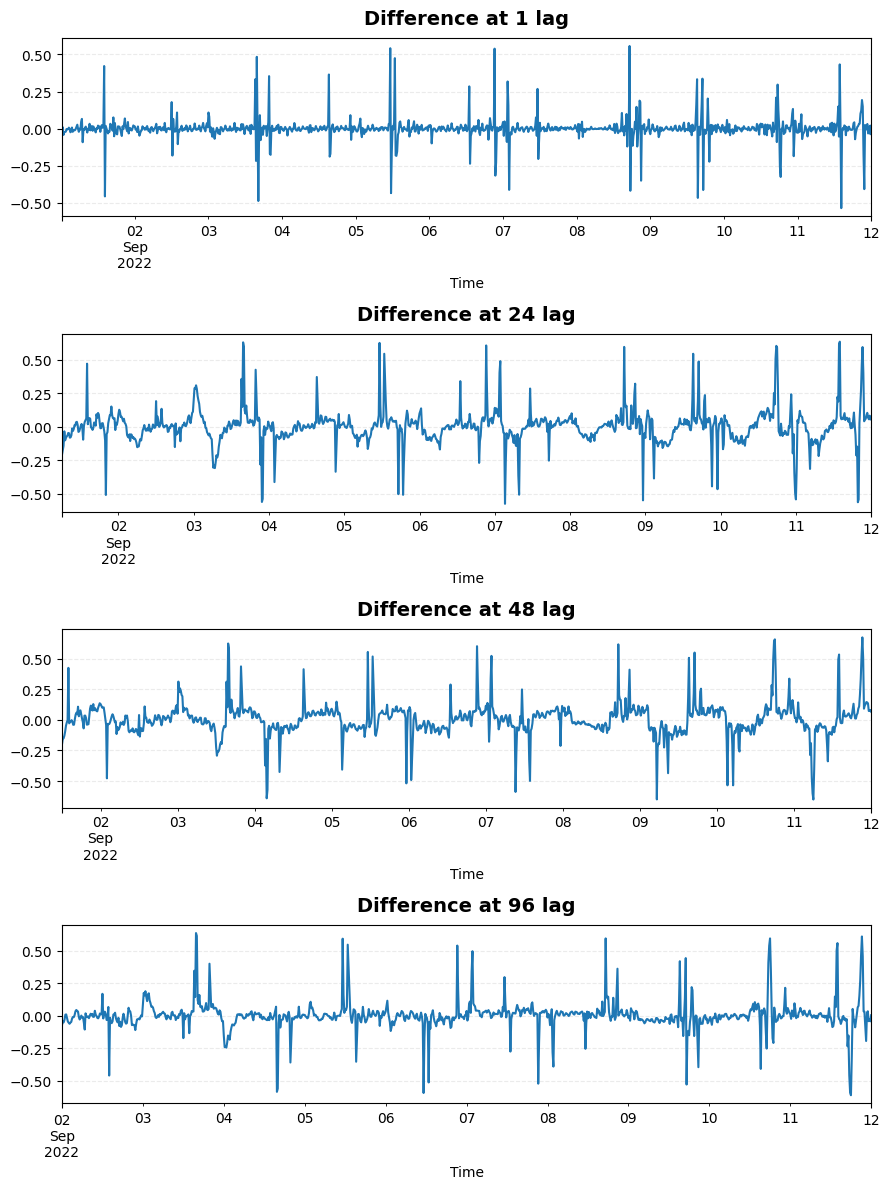

In [62]:
_,axs = plt.subplots(len(diffs), 1, figsize=(9, 3*len(diffs)))

for diff_order, ax in zip(diffs, axs):
    train_df['train'].diff(diff_order).dropna().plot(ax=ax)
    ax.set_title(f"Difference at {diff_order} lag", fontsize=14, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

From above plots we see that 1 lag difference already does a great job at making the series stationary. If we try seasonal lags too, it seems that lag 96 gives the most stationary looking one, though still less so compaired to lag 1 diff !

The stationarity intyition is confiremed by the adfuller test results for each order below:

In [63]:
for diff_order in diffs:
    print(f"\nFor lag = {diff_order}:")
    unit_root_test(train_df['train'].diff(diff_order).dropna())


For lag = 1:
p-value = 8.087207828569583e-20 => time series has no unit root

For lag = 24:
p-value = 2.4913968492338213e-13 => time series has no unit root

For lag = 48:
p-value = 8.837571381159547e-11 => time series has no unit root

For lag = 96:
p-value = 2.426449442569401e-16 => time series has no unit root


Now, we can look at ACF and PACF plots of each of the orders:

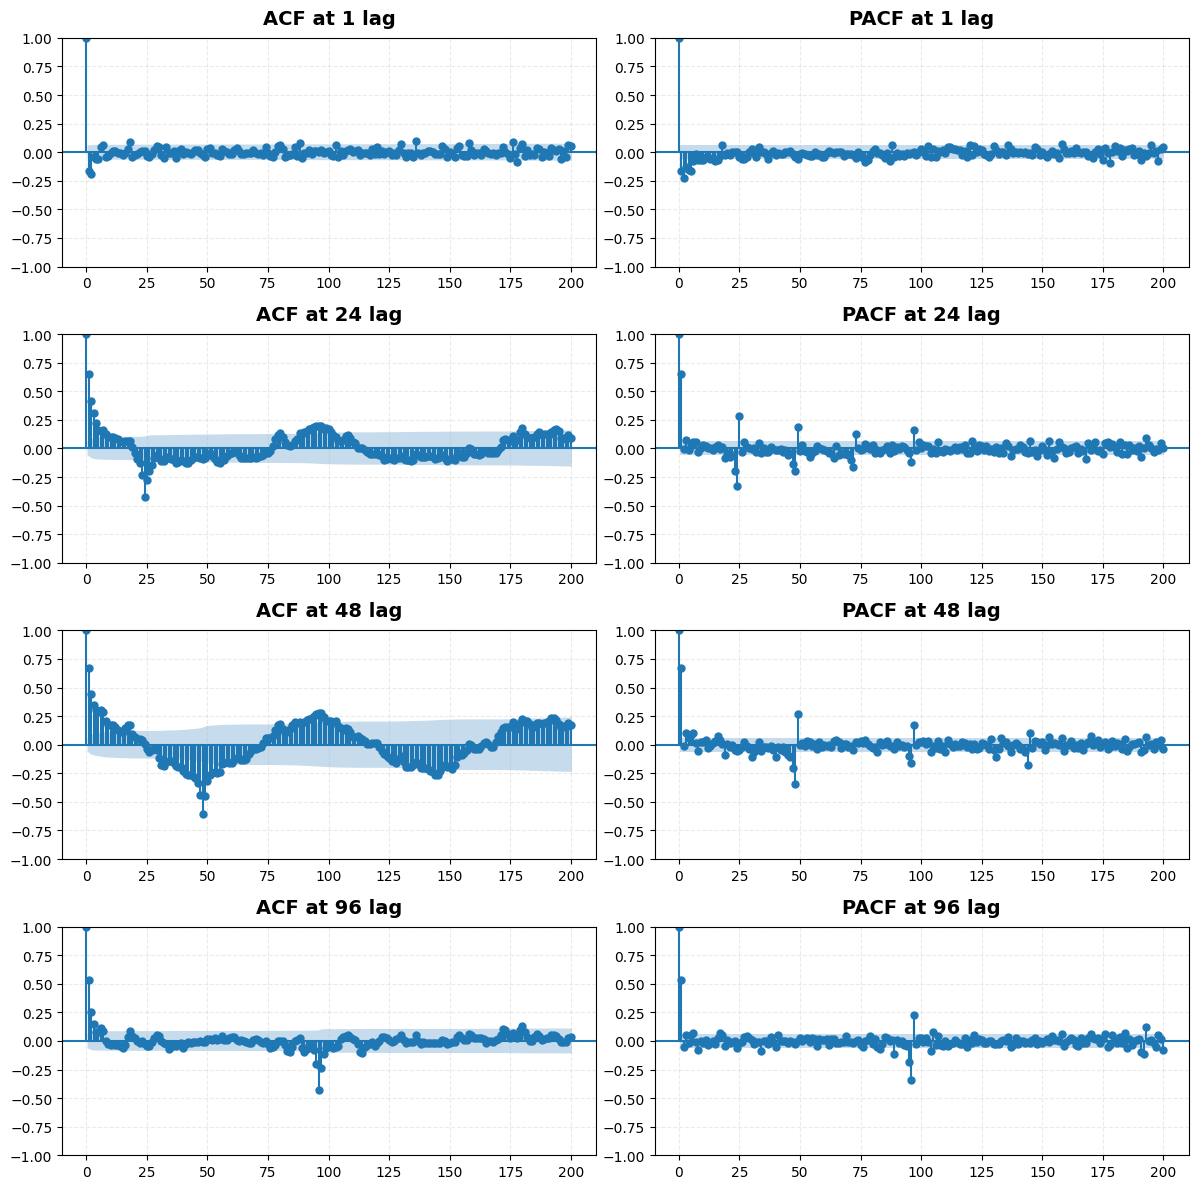

In [64]:
_,axs = plt.subplots(len(diffs), 2, figsize=(12, 3*len(diffs)))

for diff_order, ax in zip(diffs, axs):
    plot_acf(train_df['train'].diff(diff_order).dropna(), lags=200, ax=ax[0])
    plot_pacf(train_df['train'].diff(diff_order).dropna(), lags=200, ax=ax[1])
    ax[0].set_title(f"ACF at {diff_order} lag", fontsize=14, fontweight='bold', pad=10)
    ax[0].grid(True, alpha=0.25, linestyle='--')
    ax[1].set_title(f"PACF at {diff_order} lag", fontsize=14, fontweight='bold', pad=10)
    ax[1].grid(True, alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

On the plots above we indeed see that the seasonality ib ACF plot decreased significantly! We also see that both ACF and PACF have negative spikes at roughly 96 lag, suggesting we use SMA(1) - seasonal moving average at seasonal 1 lag. There is also a suspicoius looking positive correlation right after the negative spike, which is due to outbursts in the origibal plot. We might trt and also use SAR(1) later, but it is generally not the best idea as MA and AR terms can cancel each other out!

We can try and see what happens when we take first non-seasonal diff andter the seasonal 96 diff, though we have no reason to expect any improvement based on our previous observations, namely that taking a first diff doesn't impove the data:

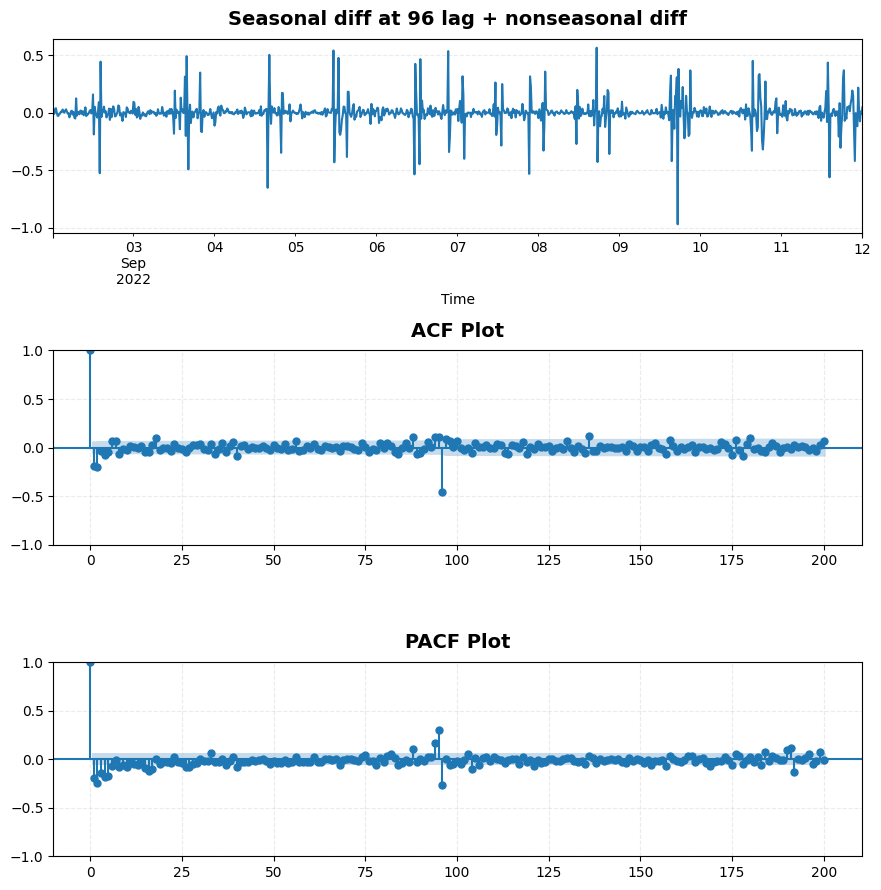

In [65]:

_,(ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 9))

train_df['train'].diff().diff(96).dropna().plot(ax=ax1)
ax1.set_title("Seasonal diff at 96 lag + nonseasonal diff", fontsize=14, fontweight='bold', pad=10)
ax1.grid(True, alpha=0.25, linestyle='--')

plot_acf(train_df['train'].diff().diff(96).dropna(), lags=200, ax=ax2)
ax2.set_title("ACF Plot", fontsize=14, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.25, linestyle='--')

plot_pacf(train_df['train'].diff().diff(96).dropna(), lags=200, ax=ax3)
ax3.set_title("PACF Plot", fontsize=14, fontweight='bold', pad=10)
ax3.grid(True, alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

On the plots above we see even more pronounced MA signature (PACF degrades gradually) suggesting that MA is possibly cancelling the fisrt non seasonal diff (the non seasonal specifically because the degradation is in first lags, not seasonal lags)

#Diff+MA Model

We figured that our series is stationary, but ACF plot suggests that differencing might be needed, as it demonstrated a strong seasonal pattern that extends indefinitely. We also see a strong MA signature, i.e. negative ACF correlation with slowly decaying PACF correlations. What makes it a MA signature is that long sequences of correlation lags are naturally captured by Moving Average model $Y_{t-1} + \theta Y_{t-2} + \theta^2Y_{t-3} + ...$ with weigh decay. Also, the AR - MA duality principal tells us that MA under some conditions is equevalent to infinite $AR(∞)$. More on all that here https://people.duke.edu/~rnau/411arim.htm

This suggests us to search through different configurations of the form (AR=0, Diff=1, MA=q), where we take q from 1 to 24 and plot the train and validation losses to controll for overfitting.

In [66]:
orders = range(1,24)

train_loss = []
val_loss = []

for x in tqdm(orders):
    order = (0, 1, x) # AR(p), diff(d), MA(q)
    seasonal_order = (0, 0, 0, 0) # SAR(p), diff(d), SMA(q), seasonal_diff(s)

    model = SARIMAX(endog = train_df['train'], order=order, seasonal_order=seasonal_order)
    results = model.fit()

    #grtting the train loss, very straighforward
    train_mse = mean_squared_error(results.fittedvalues, train_df['train'])
    train_map = mean_absolute_error(results.fittedvalues, train_df['train'])

    #getting validation loss, predict on test sets values only
    #first we extend the dataset, then use model.predict to get the predictions
    res = results.append(test_df.rename(columns={"test":"train"})["train"], refit=False)
    y_pred = res.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
    y_pred.index = test_df.index

    #now simply eval the losses, just as before
    test_mse = mean_squared_error(test_df['test'], y_pred)
    test_map = mean_absolute_error(test_df['test'], y_pred)

    train_loss.append((train_mse, train_map))
    val_loss.append((test_mse, test_map))

  0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
  4%|▍         | 1/23 [00:00<00:03,  6.11it/s]/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
  9%|▊         | 2/23 [00:00<00:05,  3.84it/s]/usr/local/lib/python3.12/dist-packages/statsm

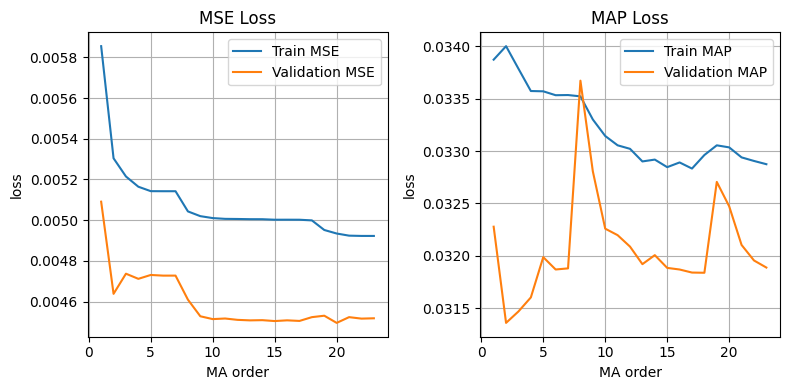

In [67]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.plot(np.array(orders), np.array(train_loss)[:,0], label="Train MSE")
ax1.plot(np.array(orders), np.array(val_loss)[:,0], label="Validation MSE")
ax2.plot(np.array(orders), np.array(train_loss)[:,1], label="Train MAP")
ax2.plot(np.array(orders), np.array(val_loss)[:,1], label="Validation MAP")

ax1.legend()
ax2.legend()

ax1.set_title("MSE Loss")
ax2.set_title("MAP Loss")

ax1.set_xlabel("MA order")
ax2.set_xlabel("MA order")

ax1.set_ylabel("loss")
ax2.set_ylabel("loss")

ax1.grid()
ax2.grid()

plt.tight_layout()
plt.show()

Now we build statistics and predictions plots for the model with the best score (order = 15)

In [68]:
model = SARIMAX(endog = train_df['train'], order=(0,1,15))
results = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


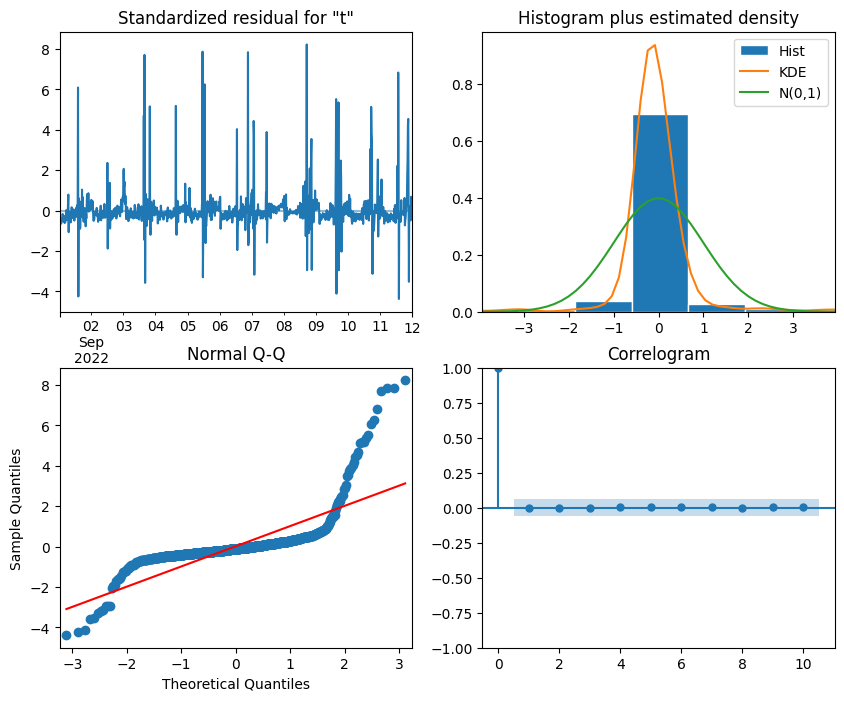

In [69]:
results.plot_diagnostics(figsize=(10,8))
plt.show()

Indeed we see that the residuals are almost white noise with no correlations. But on the Q-Q plot we can see that teh model tends to predict smaller values for big true values, which is not surprising as those big values are caused by sudden sparse spikes, ARIMA underfits them.

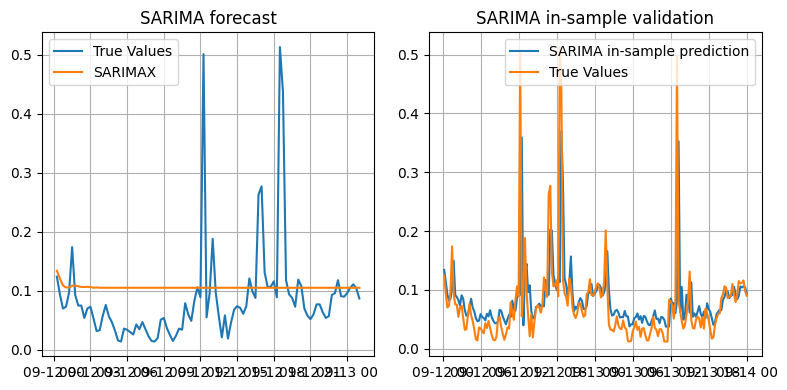

In [70]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

#plot true forecast results and copaire to true validation values
y_pred = results.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
ax1.plot(test_df['test'][:100], label="True Values")
ax1.grid(True)
ax1.set_title("SARIMA forecast")
ax1.plot(y_pred[:100], label="SARIMAX")
ax1.legend()

#append test data to the model and predict validation values with TRUE validation data as predictors
res = results.append(test_df.rename(columns={"test":"train"})["train"], refit=False)
y_pred = res.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
y_pred.index = test_df.index

ax2.plot(y_pred, label="SARIMA in-sample prediction")
ax2.plot(test_df["test"], label="True Values")
ax2.grid(True)
ax2.set_title("SARIMA in-sample validation")
ax2.legend()

plt.tight_layout()
plt.show()

###Concluding first experiment

The resulting model is not that bad after all, we see that residuals resembel white noise somewhat, we see that correlogram doesn't have significant correlations. The model seems to be able to capture the overall pattern, but, there is a but... During out of sample, pure forecasting we see that the model does well in the begining, but fails to capture the seasonal pattern in the long run! It is the property of ARIMA models that forecasting predictions normally converge to mean prediction (if the data was stationary and no bigger that 1 parameters occured). ARIMA is linear in it's arguments with decaying coefficients after all.

In order to mitigate this mean reversion, we should incorporate more differencing of higher orders, and to capture seasonality - we need seasonal differences! Though it might not give higher accuracy on the training data, it might be able to better capture the nonlinear local trend in forecasing.

#Full SARIMA

So following the previous discussion and inspired by the analysis of diff-ed sequences autocorrelations, we decide to focuse on 1 non-seasonal diff + 1 seasonal diff configuration:

1) We decided that usuall diff + seasonal diff is needed in oreder to better capture non-linear nature of the data forecasting

2) We've obsereved before, during ACF, PACF plots examination, that 96 seasonal lag stationalizes our series bettre than other seasonal lags, but still has a significant seasonal pattern in it left, which can be aliminated by an additional non-seasonal diff

3) We've also observed that combined approach PACF has MA signature in it's non-seasonal lags + SMA signature in the seasonal. This means that we should try (0,1,n)(0,1,m,96) configuration

Let's take hourly means of our data, for the reason that taking 96 lags diffs in SARIMA model is way too demanding!

In [71]:
#we use resample method that basically breaks data into bins of time length to which we apply mean() to get
#time series of hourly means, so the sequence is 4x shorter now (original frequency is 15min)
hourly_means_df = df_short.resample('1H').mean()

date_start = np.datetime64("2022-09-01")
date_end = np.datetime64("2022-09-14")

#Train-Test split
train_mask = hourly_means_df.index <= (date_end - 2)
test_mask = hourly_means_df.index > (date_end - 2)

train_df = hourly_means_df[train_mask].rename(columns = {f"Energy_Meter_{n}" : "train"})
test_df = hourly_means_df[test_mask].rename(columns = {f"Energy_Meter_{n}" : "test"})

/tmp/ipython-input-1231457937.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_means_df = df_short.resample('1H').mean()


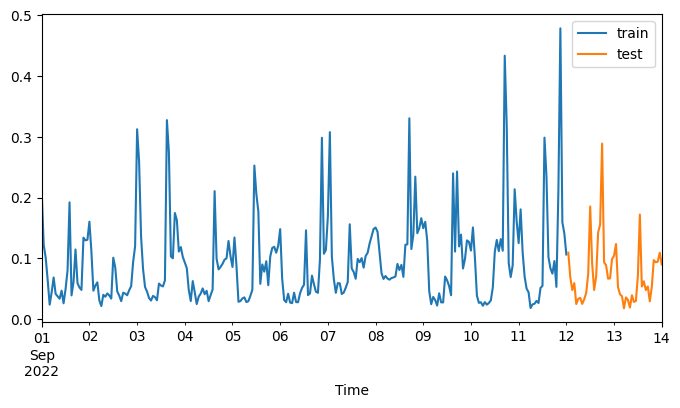

In [72]:
_,ax = plt.subplots(1,1, figsize=(8,4))
train_df.plot(ax=ax)
test_df.plot(ax=ax)
plt.show()

In [73]:
unit_root_test(train_df['train'])

p-value = 1.5804316960366879e-15 => time series has no unit root


Great, the data is still (almost) stationary! (is it that surprising though?)

The diff(24).diff() correlations below look similar still to what we have seen before:

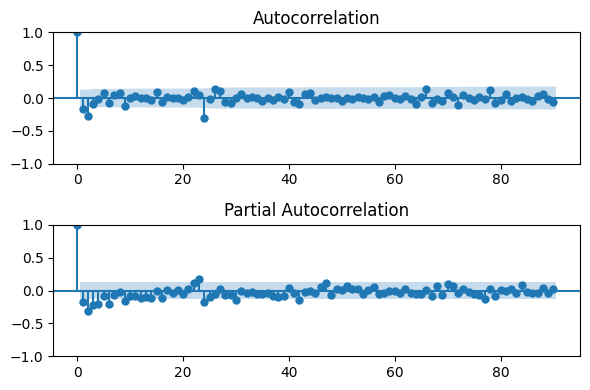

In [74]:
_,(ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))

plot_acf(train_df['train'].diff(24).diff().dropna(), lags=90, ax=ax1)
plot_pacf(train_df['train'].diff(24).diff().dropna(), lags=90, ax=ax2)
plt.tight_layout()
plt.show()

In [75]:
order = (0, 1, 12) # AR(p), diff(d), MA(q)
seasonal_order = (0, 1, 1, 24) # SAR(p), diff(d), SMA(q), seasonal_diff(s)

model = SARIMAX(endog = train_df['train'], order=order, seasonal_order=seasonal_order, method='innovations_mle')
results = model.fit()

#grtting the train loss, very straighforward
train_mse = mean_squared_error(results.fittedvalues, train_df['train'])
train_map = mean_absolute_error(results.fittedvalues, train_df['train'])

#getting validation loss, predict on test sets values only
#first we extend the dataset, then use model.predict to get the predictions
res = results.append(test_df.rename(columns={"test":"train"})["train"])
y_pred = res.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
y_pred.index = test_df.index

#now simply eval the losses, just as before
test_mse = mean_squared_error(test_df['test'], y_pred)
test_map = mean_absolute_error(test_df['test'], y_pred)

print(f"Train MSE Loss = {train_mse}\nTrain MAE Loss = {train_map}\n\nTest MSE Loss = {test_mse}\nTest MAE Loss = {test_map}")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Train MSE Loss = 0.0037125391862504365
Train MAE Loss = 0.03888259600636515

Test MSE Loss = 0.0031143640135094398
Test MAE Loss = 0.0451110772566515


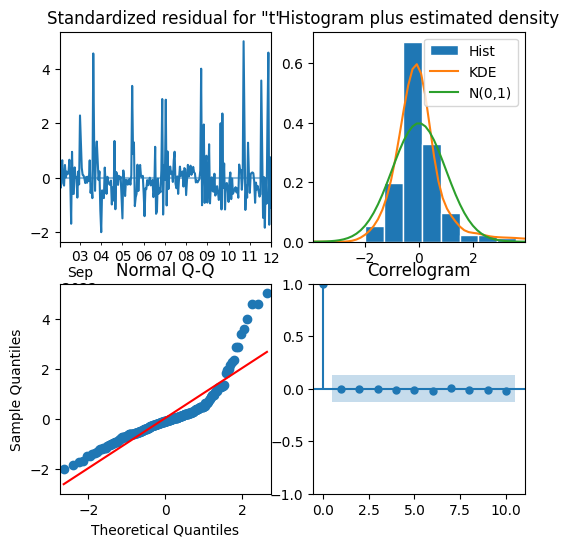

In [76]:
results.plot_diagnostics(figsize=(6,6))
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


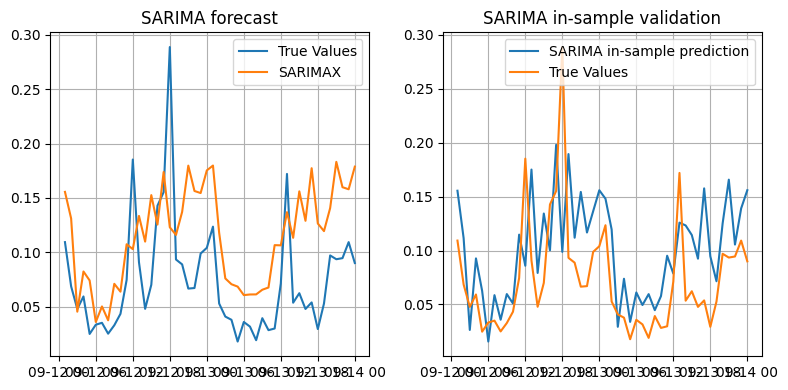

In [77]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

#plot true forecast results and copaire to true validation values
y_pred = results.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
ax1.plot(test_df['test'][:100], label="True Values")
ax1.grid(True)
ax1.set_title("SARIMA forecast")
ax1.plot(y_pred[:100], label="SARIMAX")
ax1.legend()

#append test data to the model and predict validation values with TRUE validation data as predictors
res = results.append(test_df.rename(columns={"test":"train"})["train"])
y_pred = res.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
y_pred.index = test_df.index

ax2.plot(y_pred, label="SARIMA in-sample prediction")
ax2.plot(test_df["test"], label="True Values")
ax2.grid(True)
ax2.set_title("SARIMA in-sample validation")
ax2.legend()

plt.tight_layout()
plt.show()

###Training set extentions

Let's also track how different training set lengths affect accuracy on the validation set. We'll keep the validaton set exactly the same as before, only extending the trainging set to the left.

In [78]:
date_start = np.datetime64("2022-09-01") # the begining of the original training set
date_end = np.datetime64("2022-09-14") # the end of the original validation set
val_start = date_end - 2 # fist date of val data
interval = 7 # days to skip per extention
n_extentions = 7 # how many extentions to try

# set the list of extention starts
# the corresponding training periods are [extention_start, val_start)
extention_starts = [date_start-interval*i for i in range(n_extentions)]

# this time we define hourly_means dataframe for all times
hourly_means_df = df.resample('1H').mean()
# now only keep the data before validation end
hourly_means_df = hourly_means_df[hourly_means_df.index <= date_end]

# define the validation set as before
test_mask = hourly_means_df.index >= val_start
test_df = hourly_means_df[test_mask].rename(columns = {f"Energy_Meter_{n}" : "test"})

# define the training set as the longest train extention
last_ext = extention_starts[-1]
train_mask = (hourly_means_df.index < val_start) & (hourly_means_df.index >= last_ext)
train_df = hourly_means_df[train_mask].rename(columns = {f"Energy_Meter_{n}" : "train"})


/tmp/ipython-input-4204697539.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_means_df = df.resample('1H').mean()


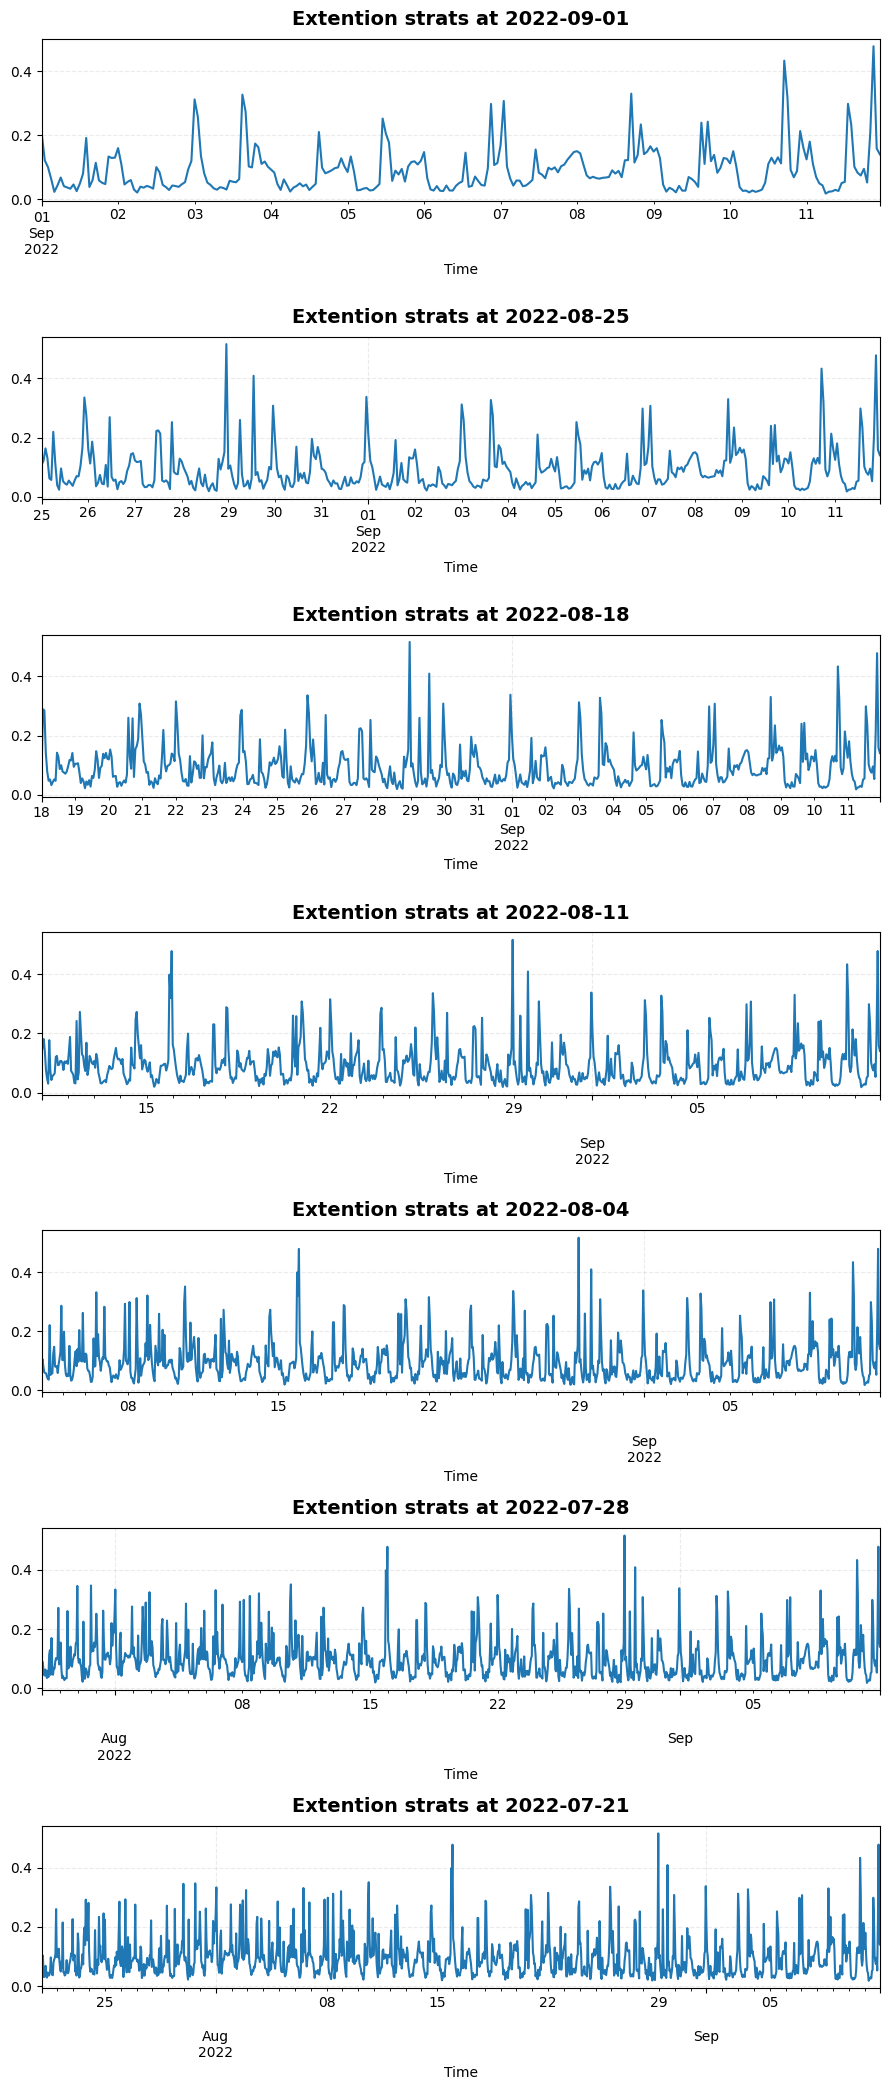

In [79]:
_,axs = plt.subplots(n_extentions, 1, figsize=(9, 3*n_extentions))

for start, ax in zip(extention_starts, axs):
    train_df[train_df.index >= start]['train'].plot(ax=ax)
    ax.set_title(f"Extention strats at {start}", fontsize=14, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

We see that the "amount" of stationarity varies amongst different slices a bit, but they are still ;almost stationary. As expected, longer sequences are less stationary. This might hurt ARIMA model performance down the line.

In [80]:
for start in extention_starts:
    print(f"\n\nTest for extention at {start} yields:")
    unit_root_test(train_df[train_df.index >= start]['train'])



Test for extention at 2022-09-01 yields:
p-value = 1.9139449277292974e-15 => time series has no unit root


Test for extention at 2022-08-25 yields:
p-value = 4.041511301155981e-11 => time series has no unit root


Test for extention at 2022-08-18 yields:
p-value = 3.192144007325215e-10 => time series has no unit root


Test for extention at 2022-08-11 yields:
p-value = 4.448407742281712e-18 => time series has no unit root


Test for extention at 2022-08-04 yields:
p-value = 2.7913896371535795e-11 => time series has no unit root


Test for extention at 2022-07-28 yields:
p-value = 6.5665625452517224e-09 => time series has no unit root


Test for extention at 2022-07-21 yields:
p-value = 1.5967890927973432e-07 => time series has no unit root


In [81]:
order = (0, 1, 12) # AR(p), diff(d), MA(q)
seasonal_order = (0, 1, 1, 24) # SAR(p), diff(d), SMA(q), seasonal_diff(s)

train_loss = []
val_loss = []

for start in tqdm(extention_starts):
    order = (0, 1, 12) # AR(p), diff(d), MA(q)
    seasonal_order = (0, 1, 1, 24) # SAR(p), diff(d), SMA(q), seasonal_diff(s)

    model = SARIMAX(endog = train_df[train_df.index >= start]['train'], order=order, seasonal_order=seasonal_order, method='innovations_mle')
    results = model.fit()

    #grtting the train loss, very straighforward
    train_mse = mean_squared_error(results.fittedvalues, train_df[train_df.index >= start]['train'])
    train_map = mean_absolute_error(results.fittedvalues, train_df[train_df.index >= start]['train'])

    #getting validation loss, predict on test sets values only
    #first we extend the dataset, then use model.predict to get the predictions
    res = results.append(test_df.rename(columns={"test":"train"})["train"], refit=False)
    y_pred = res.predict(start=len(train_df[train_df.index >= start]), end=len(train_df[train_df.index >= start])+len(test_df)-1)
    y_pred.index = test_df.index

    #now simply eval the losses, just as before
    test_mse = mean_squared_error(test_df['test'], y_pred)
    test_map = mean_absolute_error(test_df['test'], y_pred)

    train_loss.append((train_mse, train_map))
    val_loss.append((test_mse, test_map))


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 14%|█▍        | 1/7 [00:32<03:16, 32.75s/it]/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['meth

KeyboardInterrupt: 

Now we plot the results! We see that extending the training set further for 5 weeks gives higher accuracy on the validation set, but extending even further then that hurts the performance. That is due to 2 reasons:

1) As the sequence gets longer, it becomes harder to stationarize it

2) The model overfits to the data that has distributional shift as time progrecesses, so the model has to fit different distributions and performance on validation set gets worse

ValueError: x and y must have same first dimension, but have shapes (7,) and (4,)

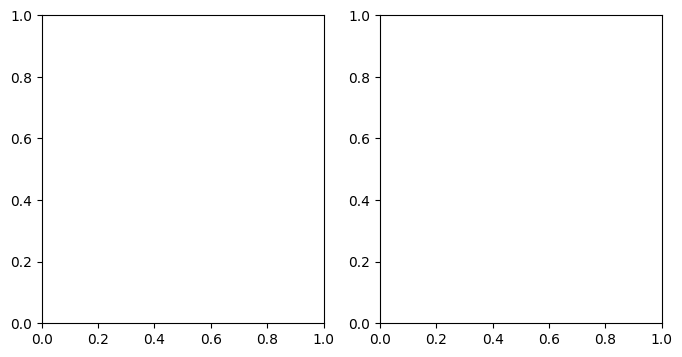

In [82]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

order = np.array(range(1, n_extentions+1))
ax1.plot(order, np.array(train_loss)[:,0], label="Train MSE")
ax1.plot(order, np.array(val_loss)[:,0], label="Validation MSE")
ax2.plot(order, np.array(train_loss)[:,1], label="Train MAP")
ax2.plot(order, np.array(val_loss)[:,1], label="Validation MAP")

ax1.legend()
ax2.legend()

ax1.set_title("MSE Loss")
ax2.set_title("MAP Loss")

ax1.set_xlabel("Extention order")
ax2.set_xlabel("Extention order")

ax1.set_ylabel("loss")
ax2.set_ylabel("loss")

ax1.grid()
ax2.grid()

plt.tight_layout()
plt.show()

#ARIMAX. ARIMA + Exogenous variables

In [83]:
# take the slice with the best score from the previous section
train_val_df =  hourly_means_df[hourly_means_df.index >= extention_starts[4]]

In [84]:
# define the validation set as before
test_mask = hourly_means_df.index >= val_start
test_df = hourly_means_df[test_mask].rename(columns = {f"Energy_Meter_{n}" : "test"})

# define the training set as the longest train extention
last_ext = extention_starts[-1]
train_mask = (hourly_means_df.index < val_start) & (hourly_means_df.index >= last_ext)
train_df = hourly_means_df[train_mask].rename(columns = {f"Energy_Meter_{n}" : "train"})

In [86]:
weather_file_name = "weather_aveiro_final.csv"

weather_df = pd.read_csv(weather_file_name).set_index("Time")
weather_df = weather_df.drop(columns=["Inst_Temp", "Max_Inst_Wind_Speed"])
weather_df.index = pd.to_datetime(weather_df.index)
weather_df = weather_df.interpolate()
weather_df = weather_df.resample('h').mean()

In [87]:
weather_df = weather_df.reindex(index=train_val_df.index)
print(f"Weather and Train dataframes time index match = {(weather_df.index == train_val_df.index).all()}")

Weather and Train dataframes time index match = True


In [106]:
unit_root_test(weather_df['Avg_Temp'].interpolate().diff().dropna())

p-value = 1.142348134911922e-21 => time series has no unit root


Let's take a look at cross-correlation between energy consumption and weather features. For that we need to make our data stationary first, because

1) otherwise the correlations will be dominated by trivial periodicity and trend in the data, not meaningful correlations! So to stationalize both energy and weather features we simple take the first diff of both

2) we forcast on diff values of energy plot, so we are most interested in correlations with not the original data, put the first diff

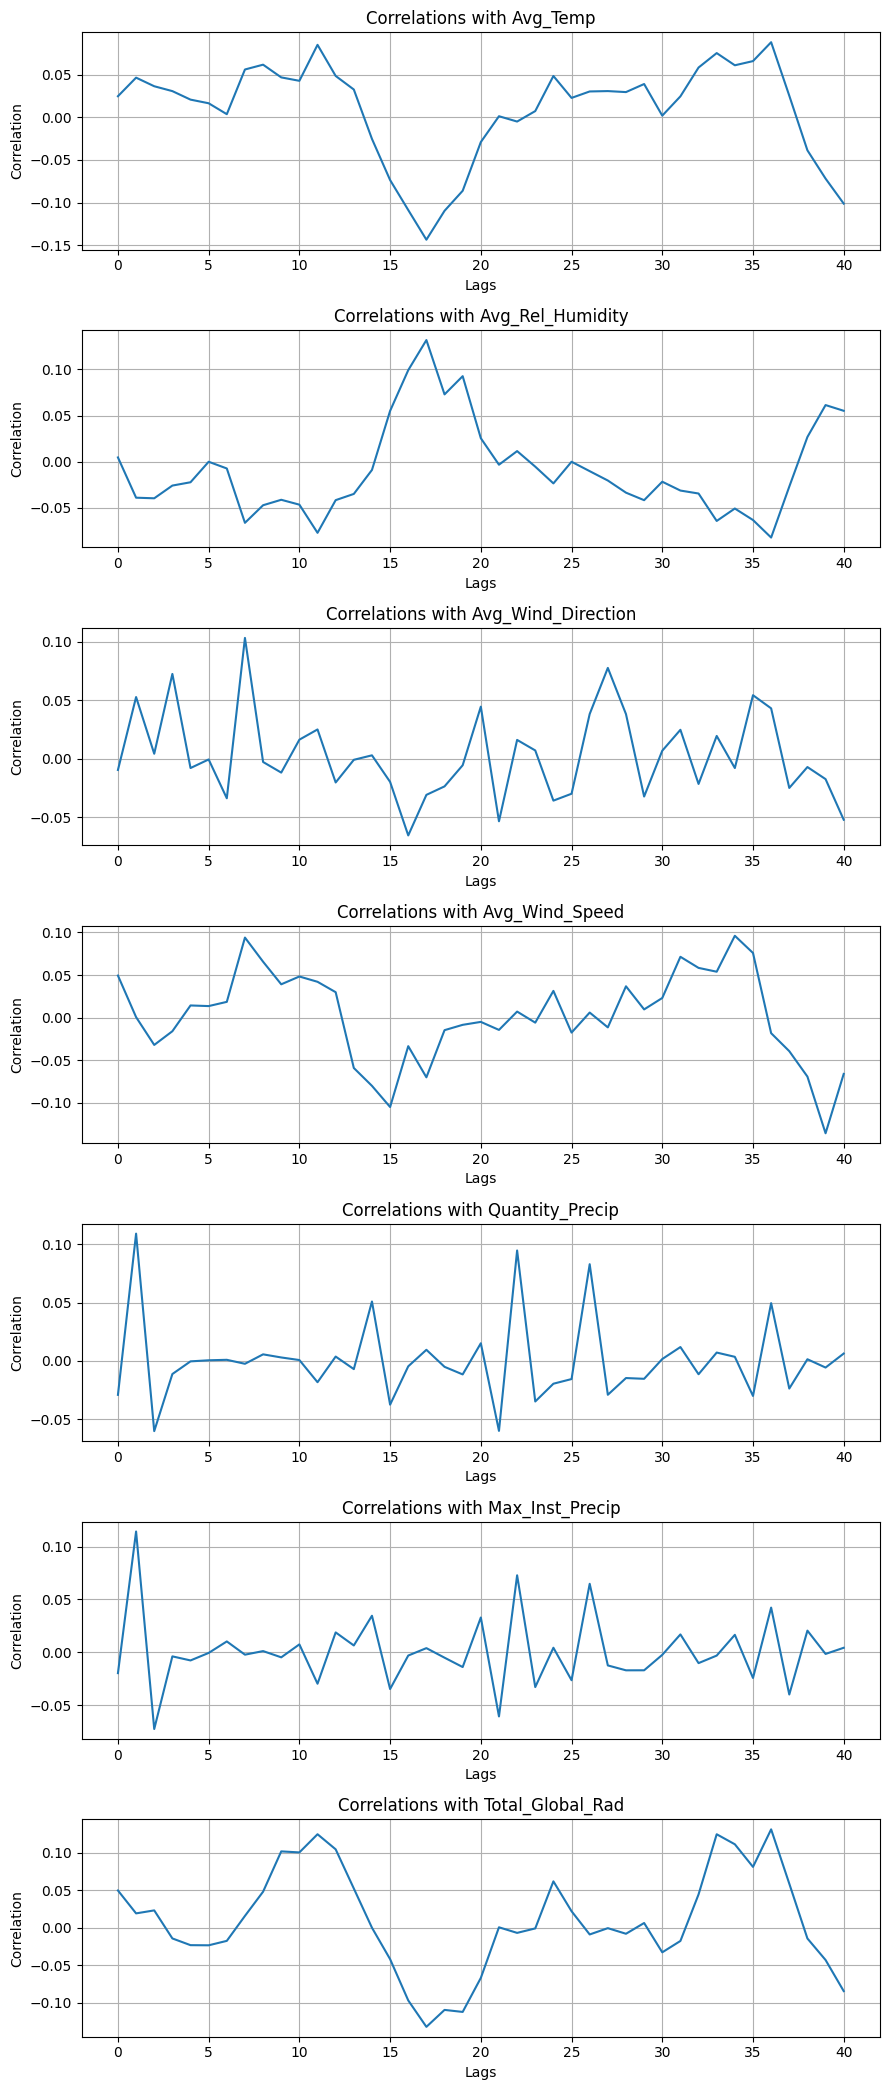

In [110]:
columns = weather_df.columns

_, ax = plt.subplots(len(columns), 1, figsize=(9, 3*len(columns)))

combined_df = train_val_df.merge(weather_df, on="Time")

n_lags = 40
n_min = 0

combined_df["Energy_stat"] = combined_df["Energy_Meter_1"].diff()

for i, name in enumerate(columns):
    vals_to_plot = []

    for k in range(n_min,n_lags+n_min+1):
        combined_df["lag"] = combined_df[name].diff().shift(k)
        vals_to_plot.append(combined_df[["Energy_stat", "lag"]].corr().iloc[0,1])

    ax[i].plot(np.array(range(n_min,n_lags+n_min+1)), np.array(vals_to_plot))
    ax[i].set_title(f"Correlations with {name}")
    ax[i].set_xlabel("Lags")
    ax[i].set_ylabel("Correlation")
    ax[i].grid(True)

plt.tight_layout()
plt.show()


Judjing by the plots, will take lags 15 to 20 of the first difference of ["Total_Global_Rad", "Avg_Wind_Speed", "Avg_Rel_Humidity", "Avg_Temp"] weather features as exogenous variables. But first, lets run our model with only endogenous features first, as before, to have something to campare with, and then add the exogenous ones.

We should also avoid including too many features as it lead to overfitting and slow convergence.

Another issue is that if we use extrogenous features as predictors, we must have access to them during foecasting too, so either out forcasting horizon is bounded by the smallest lag used, or we need to forcast the extrogenous features too, which is also not ideal as it introduces more prediction error that will accumulate over time. ***So for this reasons using 15..20 lags features that correspond to highest correlations seems about right.***

Also, this time ***we need to normalize our data***. The reason why we didn't do it before is that all the features were comming from the same distribution, and the model, which is just a linear regressor at heart, only needed to scale it's coeffs acordingly. But this time we have features from different sources (energy, temreture, wind speed etc.) so we need to make there distributions a bit more similar by setting first to moments to 0 and 1, that is normalizing the mean and variance.

We will also see that our ***loss went up, which is ok*** and nothing to worry about, it just scaled together with our data!

In [139]:
#lets put energy and weather data into one dataframe for convinience
combined_df = train_val_df.merge(weather_df, on="Time")

# we will only take lags from n_min to n_min+n_lags
n_lags = 5
n_min = 15

#list of weather data colums we'll use as features
columns = ["Total_Global_Rad", "Avg_Wind_Speed", "Avg_Rel_Humidity", "Avg_Temp"]

#names of resulting feature columns, which are diff lags of the columns
features = []

#create lagged features and out them into combined_df
for i in range(n_min,n_lags+n_min+1):
    for name in columns:
        features.append(name+f"_{i}_lags")
        combined_df[name+f"_{i}_lags"] = combined_df[name].diff().shift(i)

#drop extra columns that are not used in training
combined_df = combined_df.dropna()[['Energy_Meter_1']+features]
#normalize the clomumns by setting the mean to 0 and variance to 1
#without this step weather features only hurt the model's performance!
combined_df = (combined_df - combined_df.mean())/combined_df.std()

#train test split, keep exogenous and endogenous features separate
train_df = combined_df[combined_df.index < val_start]
test_df = combined_df[combined_df.index >= val_start]

train_targets = train_df['Energy_Meter_1']
train_exog = train_df[features]#weather_df.columns]

test_targets = test_df['Energy_Meter_1']
test_exog = test_df[features]#weather_df.columns]

In [140]:
train_exog

,Total_Global_Rad_15_lags,Avg_Wind_Speed_15_lags,Avg_Rel_Humidity_15_lags,Avg_Temp_15_lags,Total_Global_Rad_16_lags,Avg_Wind_Speed_16_lags,Avg_Rel_Humidity_16_lags,Avg_Temp_16_lags,Total_Global_Rad_17_lags,Avg_Wind_Speed_17_lags,...,Avg_Rel_Humidity_18_lags,Avg_Temp_18_lags,Total_Global_Rad_19_lags,Avg_Wind_Speed_19_lags,Avg_Rel_Humidity_19_lags,Avg_Temp_19_lags,Total_Global_Rad_20_lags,Avg_Wind_Speed_20_lags,Avg_Rel_Humidity_20_lags,Avg_Temp_20_lags
Time,,,,,,,,,,,,,,,,,,,,,
2022-08-04 21:00:00,0.136566,0.332137,-0.138294,-0.036380,0.002772,1.134247,0.212944,-0.148607,-0.000574,-0.116126,...,0.423700,-0.083099,-0.000002,0.499643,0.071816,-0.066964,-0.000006,-0.639804,0.457939,-0.275645
2022-08-04 22:00:00,0.407660,0.201283,-0.560177,0.253188,0.135812,0.330953,-0.138620,-0.035996,0.004338,1.136433,...,-0.104237,-0.244119,-0.000002,0.181830,0.423777,-0.083066,-0.000006,0.500357,0.070761,-0.066314
2022-08-04 23:00:00,0.324464,-0.509065,-0.208608,0.542756,0.406989,0.200184,-0.560496,0.253575,0.137535,0.332552,...,0.212526,-0.147507,-0.000002,-0.117289,-0.104164,-0.244086,-0.000006,0.182607,0.422741,-0.082416
2022-08-05 00:00:00,0.591409,-0.789465,-0.806276,0.800149,0.323768,-0.509704,-0.208932,0.543147,0.409030,0.201688,...,-0.139432,-0.034793,0.004910,1.135271,0.212600,-0.147474,-0.000006,-0.116451,-0.105229,-0.243440
2022-08-05 01:00:00,0.916458,0.145203,-1.263317,1.507981,0.590792,-0.789923,-0.806590,0.800544,0.325711,-0.508718,...,-0.561782,0.255043,0.138124,0.331389,-0.139360,-0.034760,0.004907,1.135856,0.211553,-0.146826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-11 19:00:00,-0.001339,-0.135197,0.494532,-0.583341,-0.002512,0.349634,0.459038,-0.727751,-0.000197,0.407332,...,-0.280216,-0.083099,-0.000002,-0.771612,0.247796,-0.260188,-0.000006,-0.751951,0.246751,-0.146826
2022-09-11 20:00:00,-0.001339,0.500377,0.213276,-0.728124,-0.002135,-0.136079,0.494195,-0.582965,-0.000952,0.351247,...,-0.491390,-0.147507,-0.000002,0.050965,-0.280145,-0.083066,-0.000006,-0.770642,0.246751,-0.259543
2022-09-11 21:00:00,0.064312,-0.172584,0.072648,-0.502905,-0.002135,0.499084,0.212944,-0.727751,-0.000574,-0.134820,...,0.458896,-0.727180,0.000376,0.406169,-0.491321,-0.147474,-0.000006,0.051769,-0.281219,-0.082416


In [136]:
order = (0, 1, 12) # AR(p), diff(d), MA(q)
seasonal_order = (0, 0, 0, 0) # SAR(p), diff(d), SMA(q), seasonal_diff(s)

model = SARIMAX(endog = train_targets, order=order, seasonal_order=seasonal_order)
results = model.fit()

#grtting the train loss, very straighforward
train_mse = mean_squared_error(results.fittedvalues, train_targets)
train_map = mean_absolute_error(results.fittedvalues, train_targets)

#getting validation loss, predict on test sets values only
#first we extend the dataset, then use model.predict to get the predictions
res = results.append(endog = test_targets, refit=False)
y_pred = res.predict(start=len(train_targets), end=len(train_targets)+len(test_targets)-1)
y_pred.index = test_targets.index

#now simply eval the losses, just as before
test_mse = mean_squared_error(test_targets, y_pred)
test_map = mean_absolute_error(test_targets, y_pred)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [137]:
print(f"Train MSE Loss = {train_mse}\nTrain MAE Loss = {train_map}\n\nTest MSE Loss = {test_mse}\nTest MAE Loss = {test_map}")

Train MSE Loss = 0.7929019802790078
Train MAE Loss = 0.578968143987332

Test MSE Loss = 0.4901832337954794
Test MAE Loss = 0.5448512573605414


In [134]:
order = (0, 1, 12) # AR(p), diff(d), MA(q)
seasonal_order = (0, 0, 0, 0) # SAR(p), diff(d), SMA(q), seasonal_diff(s)

model = SARIMAX(endog = train_targets, exog=train_exog, order=order, seasonal_order=seasonal_order)
results = model.fit()

#grtting the train loss, very straighforward
train_mse = mean_squared_error(results.fittedvalues, train_targets)
train_map = mean_absolute_error(results.fittedvalues, train_targets)

#getting validation loss, predict on test sets values only
#first we extend the dataset, then use model.predict to get the predictions
res = results.append(endog = test_targets, exog=test_exog,  refit=False)
y_pred = res.predict(start=len(train_targets), end=len(train_targets)+len(test_targets)-1)
y_pred.index = test_targets.index

#now simply eval the losses, just as before
test_mse = mean_squared_error(test_targets, y_pred)
test_map = mean_absolute_error(test_targets, y_pred)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [135]:
print(f"Train MSE Loss = {train_mse}\nTrain MAE Loss = {train_map}\n\nTest MSE Loss = {test_mse}\nTest MAE Loss = {test_map}")


Train MSE Loss = 0.7295896427213588
Train MAE Loss = 0.5534813497967338

Test MSE Loss = 0.4883260950587215
Test MAE Loss = 0.5329438226105327


In [138]:

params = pd.DataFrame({
    'Coefficient': results.params,
    'Std Error': results.bse,
    'P-value': results.pvalues
})

params = params[params['P-value'] <= 0.05]

if len(params) == 0:
    print("No parameters are statistically significant (p > 0.05)")
else:
    print(f"Found {len(params)} significant parameters:\n")
    print(params.round(4))

Found 6 significant parameters:

        Coefficient  Std Error  P-value
ma.L1       -0.5835     0.0256   0.0000
ma.L2       -0.2456     0.0351   0.0000
ma.L3       -0.1014     0.0405   0.0123
ma.L5       -0.1163     0.0438   0.0080
ma.L12       0.1054     0.0440   0.0166
sigma2       0.7877     0.0204   0.0000


So as a result, intriducing weather features brought the loss down a bit, which is good, but we also see that significance of the corresponding features is too low. That might be due to scaling issues, or that the features are only useful in tandem. But, most importantly, the validation loss went down, so we are on the right track!